# Profile Visualization 

This notebook takes input from mprofile.dat files that are created using the [mprof](http://fa.bianp.net/blog/tag/mprof.html) command and visualizes them using Pandas and Seaborn. 

In [14]:
%matplotlib inline 

import os 
import re

from glob import glob 
from datetime import datetime

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

In [41]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [49]:
# Regular expression line parsers for parsing data
cmdre = re.compile(r"^CMDLINE\s+(.+)$")
memre = re.compile(r"^MEM\s+([\d\.e]+)\s+([\d\.e]+)$")

commands = {
    "../cmd/rl -f iterator jumbo.txt": "iterator",
    "../cmd/rl -f callback jumbo.txt": "callback",
    "../cmd/rl -f channel jumbo.txt": "channel", 
    "python ../cmd/readline.py jumbo.txt": "python",
}

def parse_mprofile(path, tsidx):
    start     = None
    command   = None 
    timesteps = []
    values    = []
    
    with open(path, 'r') as f:
        for line in f:
            
            match = memre.match(line)
            if match:
                val, ts = tuple(map(float, match.groups()))
                values.append(val)
                
                if start is None: start = ts 
                ts = (ts - start) 
                
#                 ts = datetime.fromtimestamp(ts)
                timesteps.append(ts)
                
                continue 
            
            match = cmdre.match(line)
            if match:
                command = match.groups()[0]
                continue 
            
            print("Unmatchable line: \"{}\"".format(line))
    
    return pd.Series(values, timesteps, name=commands[command])

In [50]:
def load_data(paths=None, series=False):
    tsidx = time.time()
    paths = paths or glob("mprofile_*.dat")
    series = [
        parse_mprofile(path, tsidx) for path in paths
    ]
    
    if series: return series 
    return pd.concat(series, join='outer', axis = 1)

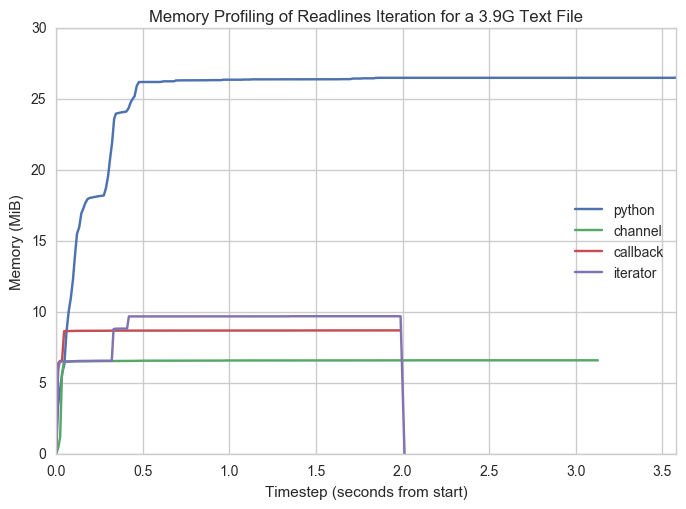

In [54]:
for series in load_data(series=True):
    series.plot(label=series.name)

plt.title("Memory Profiling of Readlines Iteration for a 3.9G Text File")
plt.ylabel("Memory (MiB)")
plt.xlabel("Timestep (seconds from start)")
plt.legend(loc='best')

plt.savefig('profile.png')